# Forecasting With Classical and Machine Learning Methods Using sktime

### What is Forecasting?

Forecasting is the process of making predictions about future events or trends by analyzing past and present data.

Forecasts are built by studying time series data.

What is time series data?

time series = recorded observations of one object or process at different time points.

observations at different time points are of same kind/type.

observations recorded with time index (= recorded time stamp)

![](../images/problem_statement.png)

![](../images/presentation_agenda.png)

![](../images/time_series_definition.png)

In [1]:
import warnings
warnings.filterwarnings("ignore")
from sktime.datasets import load_shampoo_sales

y = load_shampoo_sales()
y.head()

Period
1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

What makes time series problems unique?  

sequentiality, auto-correlation!

observations depend on previous value, e.g., passengers this year similar to last year, but not similar to 50 years ago

vs tabular ML (sklearn): data can be shuffled without altering statistical properties
("independent and identically distributed")

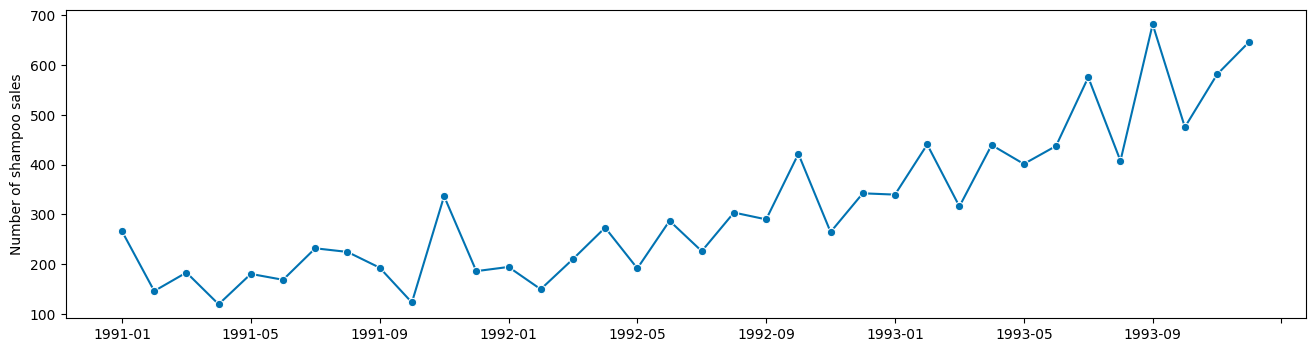

In [2]:
# airlines data
from sktime.utils.plotting import plot_series

fig, ax = plot_series(y)

autocorrelation estimator shows adjacent values are very correlated!

e.g., observations 1 period away almost perfectly correlate!

(side note for stats aficionados: usually you apply acf after differencing or stationary series, this is for illustrating autocorrelation)

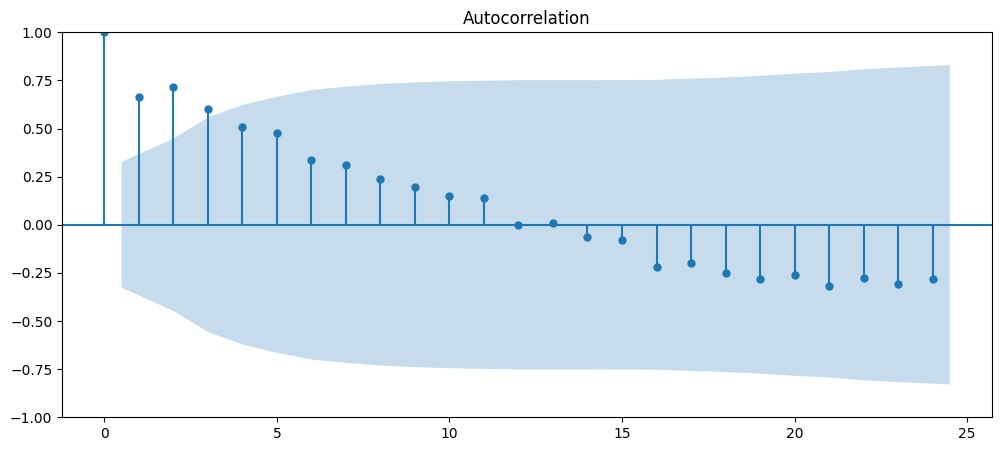

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

sm.graphics.tsa.plot_acf(y, lags=24, ax = ax)
plt.show()

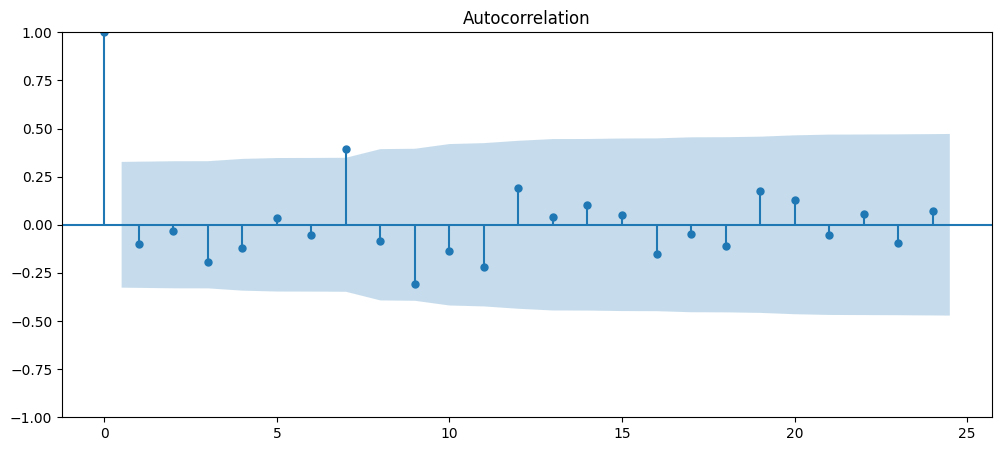

In [4]:
# for comparison, here's what this plot would look like if you shuffle this data
import numpy as np

shuffled_data = np.random.permutation(y)

fig, ax = plt.subplots(figsize=(12, 5))

sm.graphics.tsa.plot_acf(shuffled_data, lags=24, ax = ax)
plt.show()

ML models (sktime) typically built on the assumption that data is i.i.d.  

Time series models need to model temporally dependent data, trend, auto-correlation.  

Common "classical" examples of time series models: Exponential Smoothing, ARIMA, Theta, etc.  

### Classical models, ML models

"classical" models standard for forecasting up until today!

ML models with large parameters frequently underperform

#### why? theory:

auto-correlation reduces "effective sample size", roughly by 1 divided auto-correlation integral (!)

ML and DL models need large sample size for training

ineffective on low effective sample size (pre-training, global models can be way out - more later!)

##### case in point:

Monash Forecasting Repository. https://forecastingdata.org/

30 datasets study. Classical time series regularly outperform the "latest" models (dataset dependent).

Time series models often outperform more contemporary techniques.

![Monash Forecasting Results](../images/monash_respository.png)

However, there are compelling reasons to want to use ML for forecasting problems.  

 - Ability to recognize non-linear patterns
 - Ability to incorporate large amounts of non-time based exogenous data
 - Ability to capture global patterns among many time series
 - Recent successes using ML in forecasting competitions

![](../images/m5_5.png)

![](../images/m5_7.png)

![](../images/m5_6.png)

![](../images/ts_vs_ml.png)

Using ML for forecasting problems presents some issues.

Data has to undergo pre-processing to make it usable for forecasting.  

### How to use both in practice? ``sktime``'s unified interface!

time series ecosystem:

* fragmented, inhomogehous
* **many** choices for time series models - in theory and in python packages
* **inhomogenous interfaces**, pain to try/use different kinds of models

``sktime`` provides easy, flexible, unified interface for time series modelling!

![sktime](../images/unified_framework.png)


forecasting with ``sktime`` is simple!

let's pretend we want to predict shampoo sales, typical business use case (and toy data)

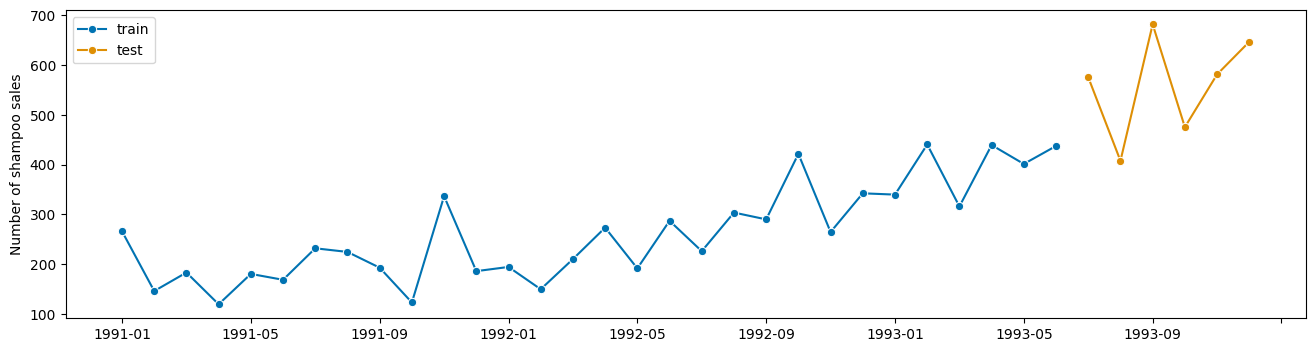

In [5]:
from sktime.datasets import load_shampoo_sales
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

y = load_shampoo_sales()

y_train, y_test = temporal_train_test_split(y=y, test_size=6)
fig, ax = plot_series(y_train, y_test, labels=["train", "test"])

as simple as this:

1. specify model
2. fit data
3. predict

(there's of course much more - evaluate, update/stream, etc)

c:\ProgramData\anaconda3\envs\sktime-skbase-311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\envs\sktime-skbase-311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


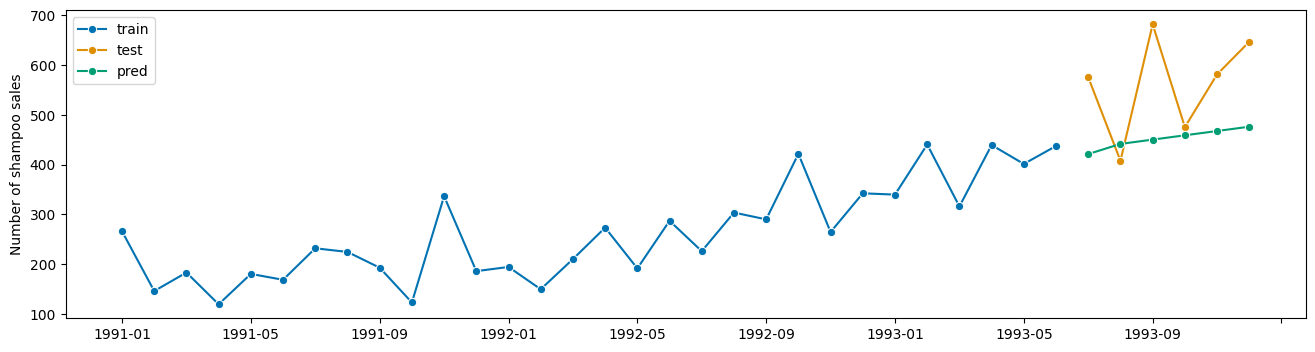

In [6]:
from sktime.forecasting.arima import AutoARIMA

# 1) Specify the model
forecaster = AutoARIMA()

# 2) Fit on train data
# need to specify "forecasting horizon" = where to forecast
fh = [1, 2, 3, 4, 5, 6] # Relative to y_train
forecaster.fit(y_train, fh=fh)

# 3) Use fitted model to predict for a certain forecast horizon
y_pred = forecaster.predict()

fig, ax = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

this is the same for any model in sktime!

classical (ARIMA etc), ML (reduction), deep learning (torch transformers), your own custom models...

* list predefined ones via `all_estimators` or check the API reference
* add your own forecaster in third party repo via extension template
* or use "building blocks" - first and third party - to build your custom model!

In [7]:
from sktime.registry import all_estimators

all_estimators(estimator_types="forecaster", as_dataframe=True)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
2,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
3,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
4,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
...,...,...
65,UpdateRefitsEvery,<class 'sktime.forecasting.stream._update.Upda...
66,VAR,<class 'sktime.forecasting.var.VAR'>
67,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
68,VECM,<class 'sktime.forecasting.vecm.VECM'>


### using tabular ML models for forecasting - "reduction"

How to prepare time series data for ML?

ML models don't have an innate ability to "see" previous samples in the data.

Key idea: "reduction"

![tabularization](../images/tabularization.png)

why "reduction"?

as in "reduce A to B" = "solve problem A (forecasting) with a solution for problem B (ML model)"

in ``sktime``: all that changes is forecaster specification

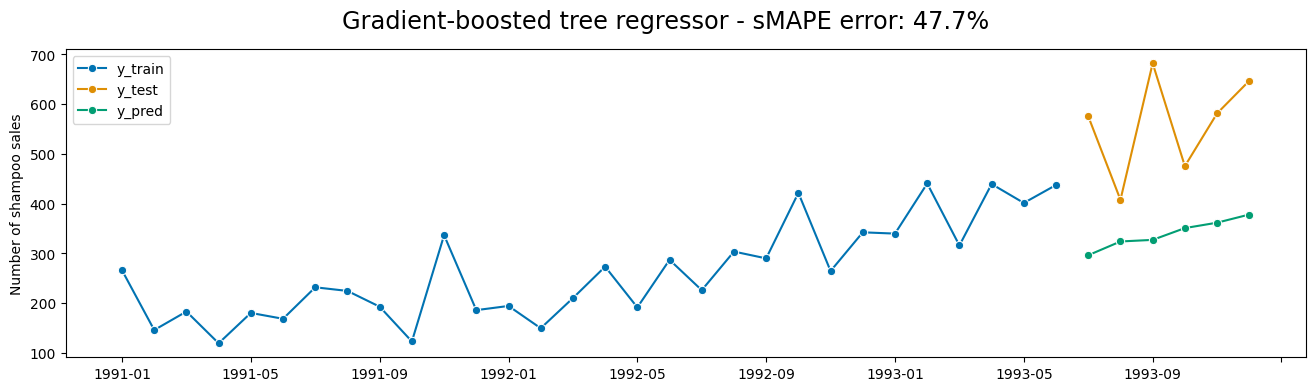

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# defining the reduction forecaster

# takes an sktime regressor...
regressor = HistGradientBoostingRegressor()

# turn it into an sklearn forecaster!
forecaster = make_reduction(regressor, strategy="direct", window_length=16)

# regressor be swapped with XBGoost, LightGBM, CatBoost, etc.

# rest is the same as for any forecaster
y_train, y_test = temporal_train_test_split(y=y, test_size=6)

fh = [1, 2, 3, 4, 5, 6]

y_pred = forecaster.fit_predict(y=y_train, fh=fh)

# plotting and evaluation
smape = MeanAbsolutePercentageError(symmetric=True)

title = f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

* `regressor` algorithm can be any estimator that has a `fit` and `predict` method.  
* `make_reduction` takes `sktime` `y`, and builds `sklearn` `X` and `y` by window/lagging

but eyeball test: predictions are bad :-(

also does does not outperform an AutoARIMA model...

In [9]:
from sktime.forecasting.arima import AutoARIMA

arima_forecaster = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
y_pred_arima = arima_forecaster.fit_predict(y=y_train, fh=fh)

print(f"Gradient-boosted tree regressor - sMAPE error: {smape(y_test, y_pred):.1%}")
print(f"AutoARIMA - sMAPE error: {smape(y_test, y_pred_arima):.1%}")

Why is the GBM under-performing?:

* Gradient boosting trees cannot "extrapolate"
* only forecast well within their observed range
* time series was non-stationary, non-iid! future range was never observed!

Solution: make (more) stationary by differencing

easy to do in `sktime`: transformers (= transformation estimators)

(note: wider concept than DL transformers, includes simple trafos like diff too)

Let's see how to use the `Differencer` transformer:

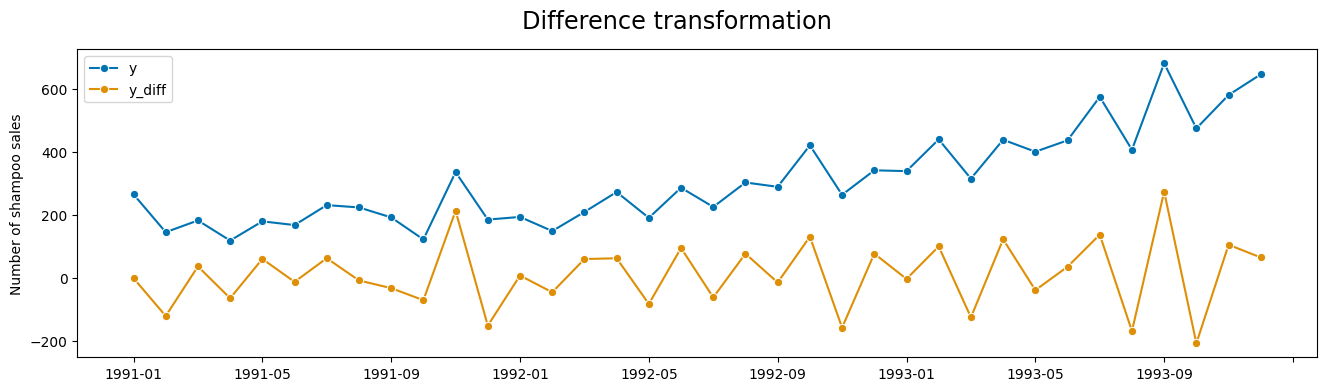

In [10]:
from sktime.transformations.series.difference import Differencer

transformer = Differencer(lags=1)
y_transform = transformer.fit_transform(y)
fig, ax = plot_series(
    y, y_transform, labels=["y", "y_diff"], title="Difference transformation"
)

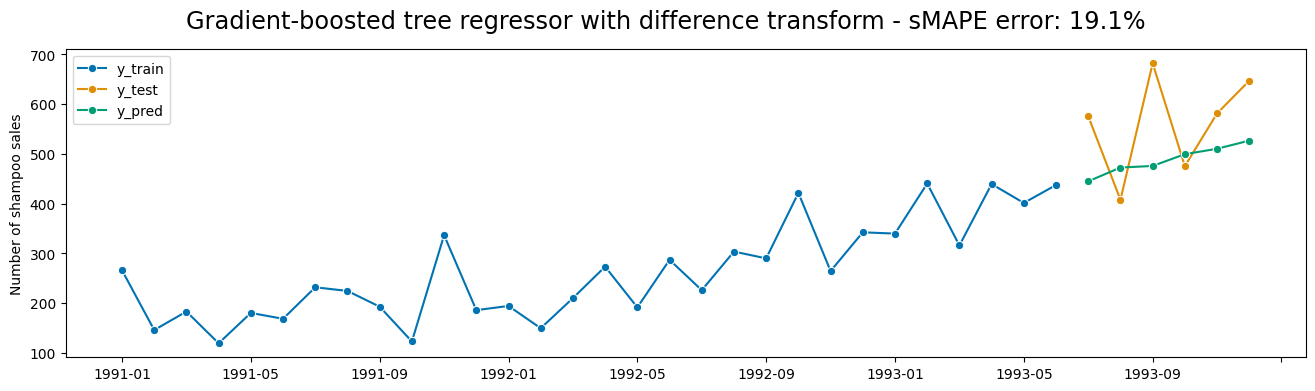

In [11]:
regressor = HistGradientBoostingRegressor()
forecaster = make_reduction(regressor, strategy="direct", window_length=16)
forecaster_with_differencer = Differencer(lags=1) * forecaster

# to do:  use transformed target forecaster for this step
y_pred = forecaster_with_differencer.fit_predict(y=y_train, fh=fh)
title = f"Gradient-boosted tree regressor with difference transform - sMAPE error: {smape(y_test, y_pred):.1%}"
fig, ax = plot_series(
    y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title=title
)

pipeline components can be chained, e.g., difference, then deseasonalize

this can drastically improve the performance of even simple forecasters!

more details on pipelines in the tutorial notebooks from [pycon Prague 2023](https://github.com/sktime/sktime-workshop-pydata-prague-2023)

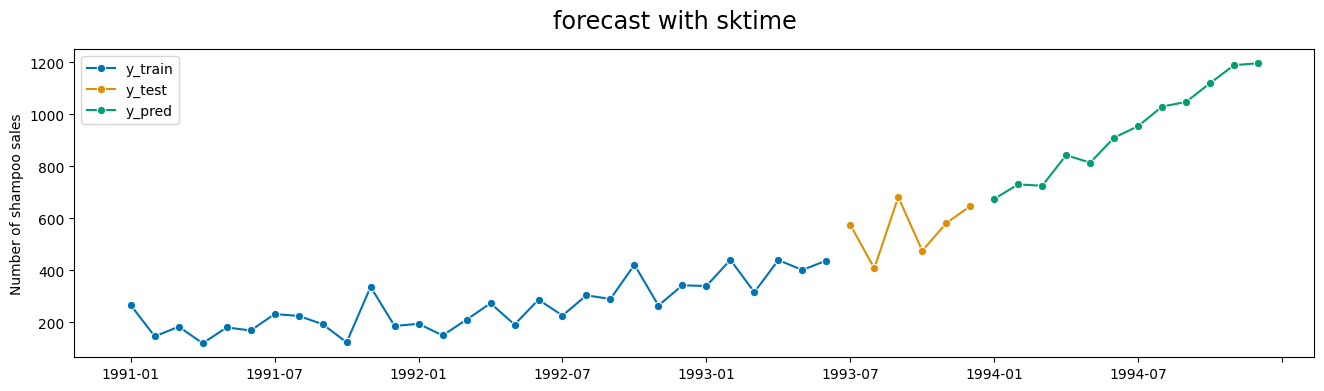

In [12]:
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer

pipe = Differencer(lags=1) * Deseasonalizer(sp=12) * TrendForecaster()

fh = list(range(1, 13))
y_pred = pipe.fit_predict(y, fh=fh)

fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], title="forecast with sktime")

We would like to take this example, extend it to account for more complicated scenarios:  

 - Forecasting many time series simultaneously, many of which may be interrelated.
 - Producing features beyond using lag values

### Panel Forecasting With ML and sktime

The examples so far have focused on a single time series.

many real world problems often involve multiple time series, many of which exist in a hierarchy.

![hierarchical time series](../images/hierarchy.png)

In [13]:
# example hierarchical time series
from pydata_utils import load_product_hierarchy

y = load_product_hierarchy()

y

Sales
Product line      Product group Date          
Food preparation  Hobs          2000-01  245.0
                                2000-02  144.0
                                2000-03  184.0
                                2000-04  265.0
                                2000-05  236.0
...                                        ...
Food preservation Fridges       2004-08  176.0
                                2004-09  205.0
                                2004-10   59.0
                                2004-11  151.0
                                2004-12  173.0

[240 rows x 1 columns]

in, hierarchical time series usually:

* individual time series related to one another
* there are many of them
* so effective sample size is large -> ML, DL benefits start to kick in!

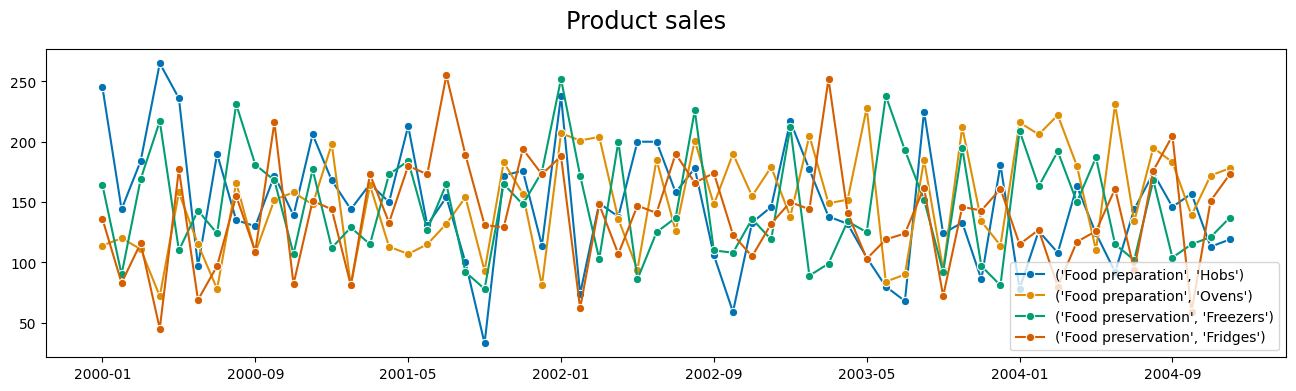

In [14]:
product_index = y.droplevel(-1).index.unique()
fig, ax = plot_series(*(y.loc[idx] for idx in product_index), labels=product_index, title="Product sales")

"baseline": individual time series modelled separately, "local"

often, better approach: fit models to all of the time series jointly! "global"

"global" approach successful used with ML models in competitions!

Both "local" and "global" approach are straightforward in `sktime`:

* "global" models fit to data as above, same interface `fit`, `predict`
* single-series models are by default "local", fit to many time series - same API!
* use `set_config` with `"backend:parallel"`, `backend:parallel:params` for "embarrassing parallelization" of local models

In [15]:
# create the train and test sets
y_train, y_test = temporal_train_test_split(y, test_size=4)

# to do:  add in differencing w/ transformed targetforecaster
regressor         = HistGradientBoostingRegressor()
forecaster_local  = make_reduction(regressor, strategy="direct", window_length=12, pooling="local")
forecaster_global = make_reduction(regressor, strategy="direct", window_length=12, pooling="global")
forecaster_arima  = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)

hier_smape = MeanAbsolutePercentageError(symmetric=True, multilevel="raw_values")

y_pred_local = forecaster_local.fit_predict(y_train, fh=[1, 2, 3, 4])
y_pred_global = forecaster_global.fit_predict(y_train, fh=[1, 2, 3, 4])
y_pred_arima = forecaster_arima.fit_predict(y_train, fh = [1, 2, 3, 4])

errors_local = hier_smape(y_test, y_pred_local)
errors_global = hier_smape(y_test, y_pred_global)
errors_arima = hier_smape(y_test, y_pred_arima)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")
print(f"Average sMAPE with AutoARIMA: {errors_arima.mean().iloc[0]:.1%}")

also available:

* hierarchical reconciliation
* configuring forecasters by node

see [advanced & hierarchical forecasting tutorial at ODSC Europe 2023](https://github.com/sktime/sktime-tutorial-ODSC-Europe-2023/tree/main)

### Combining feature engineering and reduction

Machine learning models often benefit from feature engineering beyond lags

Examples:
 - Summary statistics for a given time series
 - Window statistics for a given time series

Producing these features can easily be added to sktime pipelines.

In [16]:
from sktime.transformations.series.summarize import WindowSummarizer

# arguments for the window transformer
kwargs = {
    "lag_feature": {
        "lag": [1, 2, 3],
        "mean": [[1, 3]],
        "std": [[1, 10]],
        "kurt": [[1, 10]]},
    "truncate": 'bfill'
}

summarizer = WindowSummarizer(**kwargs, n_jobs = 1)
window_data = summarizer.fit_transform(y_train)
window_data

Sales_lag_1  Sales_lag_2  \
Product line      Product group Date                                
Food preparation  Hobs          2000-01        245.0        245.0   
                                2000-02        245.0        245.0   
                                2000-03        144.0        245.0   
                                2000-04        184.0        144.0   
                                2000-05        265.0        184.0   
...                                              ...          ...   
Food preservation Fridges       2004-04         80.0        127.0   
                                2004-05        117.0         80.0   
                                2004-06        126.0        117.0   
                                2004-07        161.0        126.0   
                                2004-08         94.0        161.0   

                                         Sales_lag_3  Sales_mean_1_3  \
Product line      Product group Date                                   
Food preparation  Hobs          2000-01        245.0      211.333333   
                                2000-02        245.0      211.333333   
                                2000-03        245.0      211.333333   
                                2000-04        245.0      191.000000   
                                2000-05        144.0      197.666667   
...                                              ...             ...   
Food preservation Fridges       2004-04        115.0      107.333333   
                                2004-05        127.0      108.000000   
                                2004-06         80.0      107.666667   
                                2004-07        117.0      134.666667   
                                2004-08        126.0      127.000000   

                                         Sales_std_1_10  Sales_kurt_1_10  
Product line      Product group Date                                      
Food preparation  Hobs          2000-01       58.815059        -1.560127  
                                2000-02       58.815059        -1.560127  
                                2000-03       58.815059        -1.560127  
                                2000-04       58.815059        -1.560127  
                                2000-05       58.815059        -1.560127  
...                                                 ...              ...  
Food preservation Fridges       2004-04       30.559414        -0.384103  
                                2004-05       30.608822        -0.433587  
                                2004-06       30.610274        -0.409658  
                                2004-07       30.476949        -0.403151  
                                2004-08       26.816247        -0.555609  

[224 rows x 6 columns]

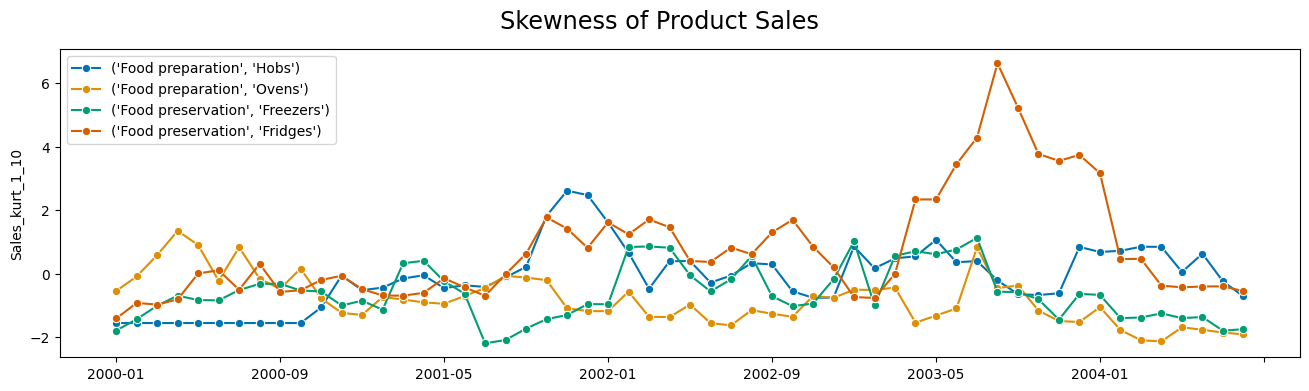

In [17]:
# window statistics can capture local patterns in a time series
# not easily observed by lag values alone
fig, ax = plot_series(*(window_data.loc[idx, 'Sales_kurt_1_10'] for idx in product_index), 
                      labels=product_index, title="Skewness of Product Sales")

In [18]:
from sktime.transformations.series.summarize import WindowSummarizer

# arguments for the window transformer
kwargs = {
    "lag_feature": {
        "lag": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "mean": [[1, 3]],
        "std": [[1, 10]],
        "kurt": [[1, 10]]},
    "truncate": 'bfill'
}

forecaster_window = make_reduction(
    regressor,
    transformers=[WindowSummarizer(**kwargs, n_jobs=1)],
    window_length=None,
    strategy="direct",
    pooling="global",
)

y_pred_global_window = forecaster_window.fit_predict(y_train, fh=[1, 2, 3, 4])
errors_global_window = hier_smape(y_test, y_pred_global_window)

print(f"Average sMAPE with local pooling: {errors_local.mean().iloc[0]:.1%}")
print(f"Average sMAPE with global pooling: {errors_global.mean().iloc[0]:.1%}")
print(f"Average sMAPE with AutoARIMA: {errors_arima.mean().iloc[0]:.1%}")
print(f"Average sMAPE with window transformations: {errors_global_window.mean().iloc[0]:.1%}")

As we can see in the above example, we've now beat the AutoARIMA baseline.  

Global forecasting may have faster fitting times than local forecasting (depends on data shape).

In [19]:
%timeit forecaster_window.fit(y_train, fh=[1, 2, 3, 4])
%timeit forecaster_arima.fit(y_train, fh=[1, 2, 3, 4])

### deep learning transformers, `pytorch` adapter

Experimental: `sktime` now has adapters for `pytorch` forecasting transformers!

Looking to expand availability of DL forecasters and ecosystem adapters.

In [75]:
from sktime.datasets import load_macroeconomic

y = load_macroeconomic()
y.shape

(203, 12)

In [98]:
# same as every sktime model - define, fit, predict!
from sktime.forecasting.ltsf import LTSFLinearForecaster

# deep learning models may have parameters set in line with fh, data, etc.
model = LTSFLinearForecaster(
    seq_len=10, pred_len=10, in_channels=y.shape[1], num_epochs=50, individual=True
)

# fit, predict
model.fit(y, fh=list(range(1, 11)))
y_pred = model.predict()

LTSFLinearForecaster(in_channels=12, individual=True, num_epochs=50,
                     pred_len=10, seq_len=10)

<Axes: xlabel='Period'>

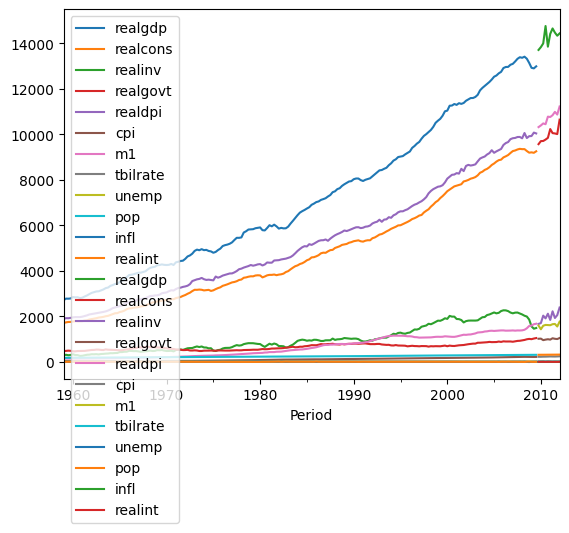

In [100]:
import matplotlib.pyplot as plt

ax = y.plot()
y_pred.plot(ax=ax)

Join the deep learning workstream if interested (testing, coding, backends...)

### Trade-offs - stats, ML, DL, foundation models?

Some "rule of thumb" recommendations:

* always try simpler models first
* always compare "simpler" to "complex"
* always compare on your own use case, benchmark performance and KPI (e.g., interpretability)

| model type   | example | best on eff. sample size | complexity | interpretability | comments |
|----------|---------------|-------|-------|-------|-------|
| naive baselines  | naive carry-forward | minimal | minimal | obvious | always include these! Point of comparison! |
| classical        | ARIMA, Exp. smoothing | small, single series | low | usually glass box | low-cost, well-understood, may underperform |
| ML, reduction    | direct reducer | medium, multiple series | mid | black box | may have feature importance, very off-shelf |
| DL, transformers | LTSF-Linear, NBEATS | varies (pretraining) | high | black box | can be pre-trained, tuned; some interpretability |
| genAI/foundation | various vendors | (unclear, tbd) | high | black box | typically only API access, customer lock-in |

**Advice: combine with pipelines!** - detrending, deseasonalizing, feature engineering can give huge performance boosts!

All model types can be combined with pipelines in the `sktime` interface. `Detrender() * Deseasonalizer(sp=12) * mymodel`

see [advanced forecasting tutorials at ODSC 2023](https://github.com/sktime/sktime-tutorial-europython-2023) or [pycon Prague 2023](https://github.com/sktime/sktime-workshop-pydata-prague-2023)

**Advice: benchmarking is important** - test on your own data! (new models: also on common benchmark cases)

Do "ablation testing" - test complex models against simpler models (e.g., simpler pipeline, less complex model)

see [sktime benchmarking tutorial at pycon Prague](https://github.com/sktime/sktime-workshop-pydata-prague-2023)

Big caveat with pre-trained DL and genAI models:

* what data could these have been trained on? in commercial solutions, often unknown
* testing performance on public benchmark datasets might result in overoptimism...

### Overview

What did we cover today?  

 - Time series models and machine learning models can both successfuly be used for forecasting
 - Time series models are easier to use "out of the box" on a single time series
 - ML models can make more sense for modeling time series simultaneously
 - You should expect to do feature engineering when time series modeling with ML
 - `sktime` provides a helpful interface for unifying the workflows for the tasks described today

Further reading:

* main `sktime` [tutorials on binder](https://mybinder.org/v2/gh/sktime/sktime/main?filepath=examples)
* recorded [video tutorials](https://www.youtube.com/playlist?list=PLKs3UgGjlWHqNzu0LEOeLKvnjvvest2d0)
* find a bug or type? [tutorial feedback thread](https://github.com/sktime/sktime/issues/1447)

---

## Join sktime!

### Vision statement

* an easy-to-use, easy-to-extend, comprehensive **python framework** for ML and AI with time series
* **open source, permissive license, free to use**
* **openly and transparently governed**
* **friendly, responsive, kind and inclusive** community, with an active commitment to ensure fairness and equal opportunity
* an academically and commercially **neutral space**, with an **ecosystem integration** ambition and neutral point of view
* an **educational platform**, providing mentoring and upskilling opportunities for all career stages, especially early career

**EVERYONE CAN JOIN! EVERYONE CAN BECOME A COMMUNITY LEADER!**

* join our community discord ([join link](https://discord.com/invite/54ACzaFsn7))!
    * **help-desk for Q&A** and getting started as a user!
    * **dev-chat** for help getting started with open source!
        * contributor [getting started guide](https://github.com/sktime/sktime/issues/1147)
        * [good first issues](https://github.com/sktime/sktime/issues?q=is%3Aissue+is%3Aopen+label%3A%22good+first+issue%22)
* join `sktime`'s user representatives or governance working group
    * register as a user ([form](https://forms.gle/eVuzrCjKDRupxawL7)) - roadmap, bugfix prio, elections
        * [roadmap 2023-2024 planning](https://github.com/sktime/sktime/issues/4691)
    * join [council sessions](https://github.com/sktime/community-org/tree/main/community_council/previous_meetings) and give input
* sktime **mentoring programme**: [link](github.com/sktime/mentoring)

Events & meetups:

* regular **community collaboration sessions**
    * meet-ups Fri 3pm UTC on [discord](https://discord.com/invite/54ACzaFsn7)
* multiple **Sprints and Dev Days** per year
    * watch [LinkedIn](https://www.linkedin.com/company/scikit-time/) for announcements!

Support us if `sktime` has generated value for you!

* star us on [GitHub](https://github.com/sktime/sktime)
* follow us on [LinkedIn](https://www.linkedin.com/company/scikit-time/)
* donate! Every cent helps the time series ecosystem ([GitHub sponsors](https://github.com/sponsors/sktime))

---

## Thank you for your attention

<img src="./img/sktime-logo-text-horizontal.jpg" alt="Sktime Logo" width="1000"/>

---
### Credits: notebook

JonathanBechtel, fkiraly, luca-miniati

based on notebooks by marrov, fkiraly, danbartl, mloning

---
### Credits: sktime

#### many thanks to [all `sktime` contributors](https://www.sktime.net/en/latest/about/contributors.html)!
Citations & credits in academic research papers:

`sktime` toolbox:
 [sktime: A unified interface for machine learning with time series](https://arxiv.org/abs/1909.07872)

`sktime` design principles: [Designing machine learning toolboxes: Concepts, principles and patterns](https://arxiv.org/abs/2101.04938)